In [0]:
!pip install torchsummary
from torchsummary import summary
from tqdm import tqdm
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
%matplotlib inline
import matplotlib.pyplot as plt

class Helper(object):

    def __init__(self):
        self.train_losses = []
        self.test_losses = []
        self.train_acc = []
        self.test_acc = []
        self.train_min_loss = []
        self.train_max_acc = []

    @staticmethod
    def get_device():
        use_cuda = torch.cuda.is_available()
        device = torch.device("cuda" if use_cuda else "cpu")
        return device

    @staticmethod
    def display_summary(model_obj, input_image_size):
        # model_obj: class objec
        # input_image_size: type int size of the image
        device = Helper.get_device()
        print("device")
        model = model_obj.to(device)
        summary(model, input_size=(1, input_image_size, input_image_size))

    @staticmethod
    def get_train_transforms(mean=0.1307, std=0.3081):
        # Train Phase transformations
        train_transforms = transforms.Compose([
            #  transforms.Resize((28, 28)),
            #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize((mean,), (std,))  # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
            # Note the difference between (0.1307) and (0.1307,)
        ])
        return train_transforms

    @staticmethod
    def get_test_transforms(mean=0.1307, std=0.3081):
        # Test Phase transformations
        test_transforms = transforms.Compose([
            #  transforms.Resize((28, 28)),
            #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize((mean,), (std,))
        ])
        return test_transforms


    @staticmethod
    def get_mean_std(path='./data', print_log=False, display_log=True):
        # simple transform
        simple_transforms = transforms.Compose([
            transforms.ToTensor(),
        ])
        exp = datasets.MNIST(path, train=True, download=True, transform=simple_transforms)
        exp_data = exp.train_data
        exp_data = exp.transform(exp_data.numpy())
        mean = torch.mean(exp_data)
        std =  torch.std(exp_data)
        if display_log:
          print('[Train]')
          print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
          print(' - Tensor Shape:', exp.train_data.size())
          print(' - min:', torch.min(exp_data))
          print(' - max:', torch.max(exp_data))
          print(' - mean:', mean)
          print(' - std:', std)
          print(' - var:', torch.var(exp_data))
        return mean, std

    # First step
    def get_train_test_data_set(self, train_transforms=None, test_transforms=None, path='./data', display_log=False):
        mean, std = Helper.get_mean_std(path=path, display_log=display_log)
        if train_transforms is None:
            train_transforms = Helper.get_test_transforms(mean, std)
        if test_transforms is None:
            test_transforms = Helper.get_test_transforms(mean, std)
        train = datasets.MNIST(path, train=True, download=True, transform=train_transforms)
        test = datasets.MNIST(path, train=False, download=True, transform=test_transforms)
        return train, test

    def view_images(self, path='./data', num_of_images=60, display_log=True):
        # We'd need to convert it into Numpy! Remember above we have converted it into tensors already
        print("The initial stastics:")
        train, test = self.get_train_test_data_set(path=path, display_log=True)
        train_data = train.train_data
        train_data = train.transform(train_data.numpy())

        print('Image data stastics')
        print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
        print(' - Tensor Shape:', train.train_data.size())
        print(' - min:', torch.min(train_data))
        print(' - max:', torch.max(train_data))
        print(' - mean:', torch.mean(train_data))
        print(' - std:', torch.std(train_data))
        print(' - var:', torch.var(train_data))

        train_loader, test_loader = self.get_data_loader(train, test, batch_size=128)
        dataiter = iter(train_loader)
        images, labels = dataiter.next()

        print(images.shape)
        print(labels.shape)

        plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')
        print("")
        self.view_defined_images(images, num_of_images)


    def view_defined_images(self, images, num_of_images):
        figure = plt.figure()
        for index in range(1, num_of_images + 1):
            plt.subplot(6, 10, index)
            plt.axis('off')
            plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

    def get_data_loader(self, train, test, batch_size=128):
        SEED = 1
        # CUDA?
        cuda = torch.cuda.is_available()
        print("CUDA Available?", cuda)

        # For reproducibility
        torch.manual_seed(SEED)

        if cuda:
            torch.cuda.manual_seed(SEED)

        # dataloader arguments - something you'll fetch these from cmdprmt
        dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

        # train dataloader
        train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

        # test dataloader
        test_loader = torch.utils.data.DataLoader(test, **dataloader_args)
        return train_loader, test_loader

    def train(self, model, device, train_loader, optimizer, epoch):
      model.train()
      pbar = tqdm(train_loader)
      correct = 0
      processed = 0
      for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred = model(data)

        # Calculate loss
        loss = F.nll_loss(y_pred, target)
        self.train_losses.append(loss.item())

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm
        
        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Train Set: Train Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        acc = float("{:.2f}".format(100*correct/processed))
        #self.train_acc.append(100*correct/processed)
        self.train_acc.append(acc)

    def test(self, model, device, test_loader):
        model.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
                pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        self.test_losses.append(test_loss)

        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

        self.test_acc.append(100. * correct / len(test_loader.dataset))


    # second step
    def train_test_model(self, model_obj, EPOCHS=20, batch_size=128, path='./data', optimizer=None):
        # Train and test our model
        device = Helper.get_device()
        model = model_obj.to(device)
        if optimizer is None:
            optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        train, test =  self.get_train_test_data_set(path=path)
        train_loader, test_loader = self.get_data_loader(train, test, batch_size)
        for epoch in range(1, EPOCHS+1):
            print("EPOCH:", epoch)
            self.train(model, device, train_loader, optimizer, epoch)
            self.test(model, device, test_loader)
            self.train_max_acc.append(self.train_acc[-1])
            self.train_min_loss.append(self.train_losses[-1])

    @staticmethod
    def calculate_diff(train, test):
        zip_obj = zip(train, test)
        diff = [train_i-test_i for train_i, test_i in zip_obj]
        return diff

    def display_plot(self):
        try:
            fig, axs = plt.subplots(2,2,figsize=(15,10))
            axs[0, 0].plot(self.train_losses)
            axs[0, 0].set_title("Training Loss")
            axs[1, 0].plot(self.train_acc)
            axs[1, 0].set_title("Training Accuracy")
            axs[0, 1].plot(self.test_losses)
            axs[0, 1].set_title("Test Loss")
            axs[1, 1].plot(self.test_acc)
            axs[1, 1].set_title("Test Accuracy")
            print('Train loss: ',self.train_min_loss)
            print('Test loss: ',self.test_losses)
            print("Difference in loss : ", Helper.calculate_diff(self.train_min_loss, self.test_losses))
            print('Train Accuracy: ',self.train_max_acc)
            print('Test Accuracy: ',self.test_acc)
            print("Difference in Accuracy : ", Helper.calculate_diff(self.train_max_acc, self.test_acc))
        except Exception as e:
            print("First train the model")

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        try:
            return False
        except Exception as e:
            print(str(e))
            pass

In [0]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
                # OUTPUT BLOCK
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 7
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
            # nn.BatchNorm2d(10), NEVER
            # nn.ReLU() NEVER!
        ) # output_size = 1
    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

device
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
            Conv2d-4           [-1, 10, 24, 24]             900
       BatchNorm2d-5           [-1, 10, 24, 24]              20
              ReLU-6           [-1, 10, 24, 24]               0
            Conv2d-7           [-1, 20, 22, 22]           1,800
       BatchNorm2d-8           [-1, 20, 22, 22]              40
              ReLU-9           [-1, 20, 22, 22]               0
        MaxPool2d-10           [-1, 20, 11, 11]               0
           Conv2d-11           [-1, 10, 11, 11]             200
      BatchNorm2d-12           [-1, 10, 11, 11]              20
             ReLU-13           [-1, 10, 11, 11]               0
           Conv2d-14            

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
  0%|          | 0/469 [00:00<?, ?it/s]

CUDA Available? True
EPOCH: 1


Train Set: Train Loss=0.09498176723718643 Batch_id=468 Accuracy=94.15: 100%|██████████| 469/469 [00:15<00:00, 30.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0618, Accuracy: 9805/10000 (98.05%)

EPOCH: 2


Train Set: Train Loss=0.0682760551571846 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:15<00:00, 30.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0461, Accuracy: 9869/10000 (98.69%)

EPOCH: 3


Train Set: Train Loss=0.05459217727184296 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:15<00:00, 31.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0340, Accuracy: 9892/10000 (98.92%)

EPOCH: 4


Train Set: Train Loss=0.014920681715011597 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:15<00:00, 30.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0337, Accuracy: 9883/10000 (98.83%)

EPOCH: 5


Train Set: Train Loss=0.018449073657393456 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:14<00:00, 31.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0297, Accuracy: 9910/10000 (99.10%)

EPOCH: 6


Train Set: Train Loss=0.010723615996539593 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:15<00:00, 30.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0359, Accuracy: 9877/10000 (98.77%)

EPOCH: 7


Train Set: Train Loss=0.001377443433739245 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:15<00:00, 30.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0332, Accuracy: 9897/10000 (98.97%)

EPOCH: 8


Train Set: Train Loss=0.01000263262540102 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:14<00:00, 31.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Accuracy: 9905/10000 (99.05%)

EPOCH: 9


Train Set: Train Loss=0.00922850240021944 Batch_id=468 Accuracy=99.48: 100%|██████████| 469/469 [00:15<00:00, 31.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0266, Accuracy: 9920/10000 (99.20%)

EPOCH: 10


Train Set: Train Loss=0.02418769896030426 Batch_id=468 Accuracy=99.56: 100%|██████████| 469/469 [00:15<00:00, 30.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0326, Accuracy: 9891/10000 (98.91%)

EPOCH: 11


Train Set: Train Loss=0.0012089014053344727 Batch_id=468 Accuracy=99.62: 100%|██████████| 469/469 [00:15<00:00, 31.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0273, Accuracy: 9919/10000 (99.19%)

EPOCH: 12


Train Set: Train Loss=0.00574059272184968 Batch_id=468 Accuracy=99.67: 100%|██████████| 469/469 [00:14<00:00, 31.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0317, Accuracy: 9896/10000 (98.96%)

EPOCH: 13


Train Set: Train Loss=0.0065494379960000515 Batch_id=468 Accuracy=99.70: 100%|██████████| 469/469 [00:14<00:00, 32.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0324, Accuracy: 9898/10000 (98.98%)

EPOCH: 14


Train Set: Train Loss=0.0030000607948750257 Batch_id=468 Accuracy=99.73: 100%|██████████| 469/469 [00:15<00:00, 30.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0273, Accuracy: 9909/10000 (99.09%)

EPOCH: 15


Train Set: Train Loss=0.004320735577493906 Batch_id=468 Accuracy=99.77: 100%|██████████| 469/469 [00:14<00:00, 31.40it/s]



Test set: Average loss: 0.0272, Accuracy: 9920/10000 (99.20%)

Train loss:  [0.09498176723718643, 0.0682760551571846, 0.05459217727184296, 0.014920681715011597, 0.018449073657393456, 0.010723615996539593, 0.001377443433739245, 0.01000263262540102, 0.00922850240021944, 0.02418769896030426, 0.0012089014053344727, 0.00574059272184968, 0.0065494379960000515, 0.0030000607948750257, 0.004320735577493906]
Test loss:  [0.06184329867362976, 0.04614128663539886, 0.03404009737968445, 0.03374745626449585, 0.029701774144172667, 0.03594408829212189, 0.03319660153388977, 0.029017632293701173, 0.026562687039375307, 0.03261679842472076, 0.02734262022972107, 0.0317336407661438, 0.032379222083091734, 0.027260423755645753, 0.0271895521402359]
Difference in loss :  [0.03313846856355667, 0.02213476852178574, 0.020552079892158508, -0.018826774549484254, -0.011252700486779212, -0.025220472295582295, -0.03181915810015053, -0.019014999668300153, -0.017334184639155866, -0.0084290994644165, -0.026133718824386597

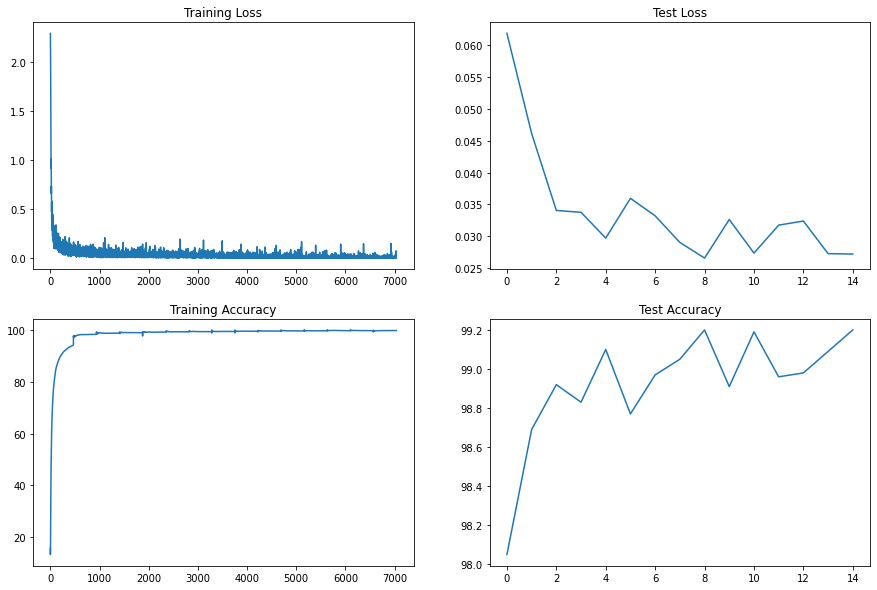

In [0]:
with Helper() as helper_obj:
  obj1 = Net2()
  helper_obj.display_summary(obj1, 28)
  #helper_obj.view_images()
  helper_obj.train_test_model(obj1, EPOCHS=15, batch_size=128)
  helper_obj.display_plot()